In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [68]:
# Assumptions about the space where the collisions will happen.
#
# These are used to bound the rays that are the paths of the hailstones when 
# searching for where they might collide

BOX_MIN = 0
BOX_MAX = 600_000_000_000_000

In [69]:
class Hail:
    """
    Information about one hailstone: 
        p - The point where it starts at time t=0 
        v - The velocity vector that is the movement at each tick of time.
    """
    def __init__(self, p, v):
        self.p = np.array(p)
        self.fp = float_array(p)
        self.v = np.array(v)
        self.fv = float_array(v)

    def __str__(self):
        return repr(self)

    def __repr__(self):
        return "Hail({0}, {1})".format(self.p, self.v)

    def num_ticks(self):
        """How many clock ticks will this hailstone stay within BOX_MIN / BOX_MAX in all dimensions?"""
        def one_axis(pos_and_vel):
            (p, v) = pos_and_vel
            assert BOX_MIN <= p <= BOX_MAX
            if v < 0:
                ticks = (p - BOX_MIN) // (-v)
            else:
                ticks = (BOX_MAX - p) // v
            return ticks 
            
        return min(one_axis(p_and_v) for p_and_v in zip(self.p, self.v))

    def at_time(self, t):
        """Where is this stone at time t?"""
        return self.p + t * self.v

    def at_time_f(self, t): 
        """Where is this stone at time t, in floating point?"""
        return self.fp + t * self.fv

    def at_fraction(self, frac):
        """Where is this stone at a given fraction of its travel?

        0.0 is at the point where the stone starts
        1.0 is at the point where it leaves the bounding box.
        """
        t = frac * self.num_ticks()
        return self.at_time_f(t)

    def ticks_at_fraction(self, frac):
        """At the given fraction of its travel, how many ticks have passed?"""
        return frac * self.num_ticks()

    def other_end(self):
        """Return the end opposite the starting end"""
        return self.at_fraction(1.0)

def float_array(v):
    """Convert a list of ints to a numpy floating vector"""
    return np.array([float(x) for x in v])

In [70]:
# The input file consists of lines with the starting position and velocity of a hailstone:
#  '197869613734967, 292946034245705, 309220804687650 @ 150, 5, -8'
#
# Parse them and turn them into a list of Hail objects.
#

def parse_coords(s):
    return [int(x) for x in s.split()]
    
def parse_input_line(line):
    sides = line.replace(",", "").split("@")
    return Hail(parse_coords(sides[0]), parse_coords(sides[1]))
    
def read_input_file():
    with open("input.txt") as f:
        input_text = f.read()
    input_lines = input_text.splitlines()
    hail_lines = input_lines[1:]
    return [parse_input_line(line) for line in hail_lines]

hails = read_input_file() 
len(hails)

300

In [71]:
def distance_between_two_lines(p1, v1, p2, v2):
    """Distance between two lines.

    Each line is specified as a point and a directional vector.
    
    Original source: https://math.stackexchange.com/questions/2213165/find-shortest-distance-between-lines-in-3d 
    """

    # Find the unit vector n perpendicular to both lines
    n = np.cross(v1, v2)
    n /= np.linalg.norm(n)

    # Calculate distance by projecting a vector from one line to the other
    # onto the perpendicular unit vector.
    return np.dot(n, p1 - p2)

In [72]:
def sum_of_distances_fcn(h1, h2, all_hails):
    """Create a function that calculates the sum of distances from a line to all hailstone paths.

    The line is specified by two points, one on hailstone h1's path, and one on h2's path.
    """
    def f(frac1, frac2):
        """Given a fraction of travel for each hailstone, what's the sum of distances to that line?"""
        p1 = h1.at_fraction(frac1)
        p2 = h2.at_fraction(frac2)
        v = p2 - p1
        return sum(abs(distance_between_two_lines(p1, v, h.fp, h.fv)) for h in all_hails)
    return f 

# Create a function for two specific hailstones.  
# This pair (161, 250) results in a nice smooth surface.  Found by trying a dozen different pairs.
hailA = hails[161]
hailB = hails[250]
surface_f = sum_of_distances_fcn(hailA, hailB, hails)

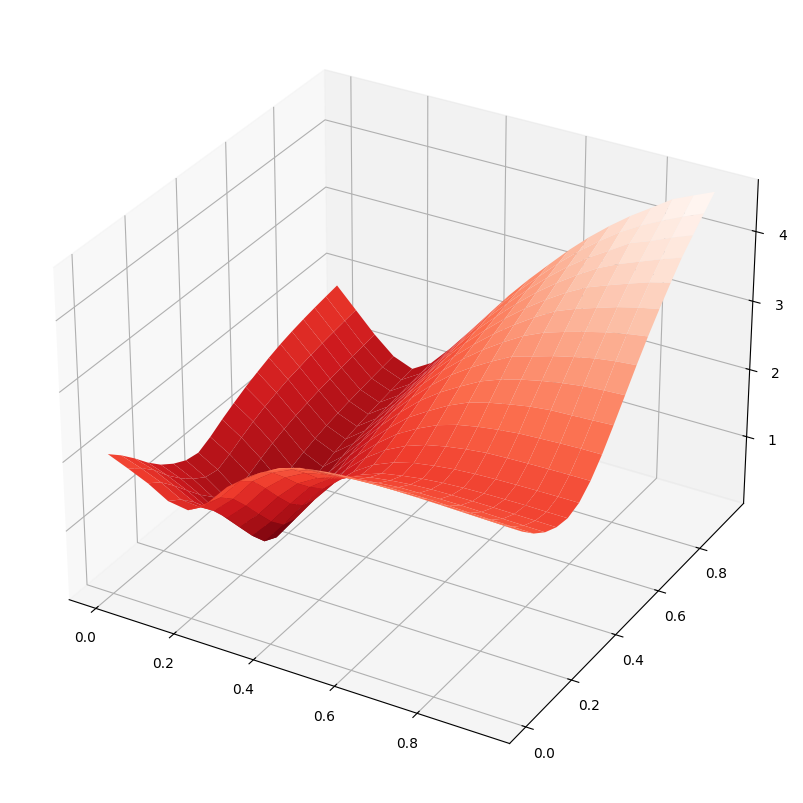

In [73]:
# Draw the surface.
# Based on: https://matplotlib.org/stable/plot_types/3D/surface3d_simple.html

from matplotlib import cm

plt.style.use('_mpl-gallery')

@np.vectorize
def surface(x, y):
    """A version of `surface_f` that works on numpy vectors"""
    return surface_f(x, y)

# Make data
X = np.arange(0.0, 1.0, 0.05)
Y = np.arange(0.0, 1.0, 0.05)
X, Y = np.meshgrid(X, Y)
Z = surface(X, Y)

# Plot the surface
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8, 8))
ax.plot_surface(X, Y, Z, vmin=Z.min() * 2, cmap=cm.Reds.reversed())

plt.show()

In [74]:
def search(f, x0, x1, y0, y1):
    """Search for the minimum / zero point

    Strategy is to:
      - grid of the area into a 20x20 grid, 
      - find the lowest point, 
      - shrink the search area to 2 grid units around the low point
      - repeat
    """
    for i in range(0, 22):
        dx = (x1 - x0) / 20.0
        dy = (y1 - y0) / 20.0
        min_d = None
        for x in np.arange(x0, x1 + dx/2, dx):
            for y in np.arange(y0, y1 + dy/2, dy):
                d = surface_f(x, y)
                if min_d == None or d < min_d:
                    min_x = x
                    min_y = y
                    min_d = d
        print(i, min_x, min_y, min_d)
        
        x0 = min_x - 2 * dx
        x1 = min_x + 2 * dx
        y0 = min_y - 2 * dy
        y1 = min_y + 2 * dy
        
    return (min_x, min_y)

(fracA, fracB) = search(surface_f, 0.0, 1.0, 0.0, 1.0)
(fracA, fracB)

0 0.2 0.35000000000000003 825178563326131.1
1 0.19000000000000009 0.3400000000000001 270857468588002.8
2 0.19200000000000012 0.3380000000000001 82564692009054.61
3 0.19280000000000025 0.3376000000000002 16496727582859.258
4 0.19296000000000021 0.33744000000000035 2156453221962.053
5 0.19299200000000008 0.33745600000000053 551635397035.5906
6 0.19298560000000015 0.33745600000000037 67966237028.03602
7 0.19298496000000012 0.3374560000000003 19776584079.108078
8 0.19298470400000003 0.3374560000000002 2030078337.5875702
9 0.19298470400000012 0.3374559488000003 97812322.64857483
10 0.1929847040000002 0.33745594880000007 97812314.35495758
11 0.19298470502400017 0.337455947776 3146339.065513611
12 0.19298470502400028 0.33745594777600013 3146350.145126343
13 0.19298470502400014 0.3374559476940802 1716411.985786438
14 0.19298470500761616 0.3374559477104642 159913.23205566406
15 0.19298470500597786 0.33745594771210274 8585.892166137695
16 0.1929847050059779 0.3374559477124304 5300.300086975098
1

(0.1929847050059999, 0.33745594771231147)

In [45]:
#
# Find the integer locations of hail stones A and B at the intersection points with the line we found. 
#

@np.vectorize
def rnd(x):
    return round(x)
    
pA, pB = (rnd(hailA.at_fraction(fracA)), rnd(hailB.at_fraction(fracB)))
(pA, pB)

(array([286964480315492, 244757496958770, 290468276088071]),
 array([282612955677240, 375303236106330, 326467252640883]))

In [47]:
# Find the times when the rock intersects with hailstones A and B

tA, tB = (round(hailA.ticks_at_fraction(fracA)), round(hailB.ticks_at_fraction(fracB)))
(tA, tB)

(427756576238, 823349725170)

In [49]:
# What's the velocity of the rock?

vR = (pB - pA) // (tB - tA)
vR

array([-11, 330,  91])

In [56]:
# What's the starting position of the rock?

pR = pA - tA * vR
pR

array([291669802654110, 103597826800230, 251542427650413])

In [80]:
# Double check that the math works

# A hailstone with the path of the rock
rock = Hail(pR, vR)

# The rock should be at the same place as the two hailstones at the appointed times
assert all(rock.at_time(tA) == hailA.at_time(tA))
assert all(rock.at_time(tB) == hailB.at_time(tB))

In [58]:
# The answer is the sum of x, y, and z at the starting position of the rock
sum(pR)

646810057104753